In [ ]:
!pip install control

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
 
# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Semesterproject 1/Code/KalmanNet_control/'
assert FOLDERNAME is not None, "[!] Enter the foldername."
 
# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [ ]:
from system_controller import Controller
from system_model_lqr import SystemModelLQR
from systems import LinearSystem
from system_knet_linear import KalmanNetNN

import torch
from datetime import datetime
import matplotlib.pyplot as plt
import os
from math import log10, cos, sin, pi
import control

Running on the CPU


In [ ]:
#############
### Model ###
#############
dtype_ = torch.float32
q2 = 1  # process noise variance
r2 = 1   # observation noise variance
T = 100    # trajectory length / time horizon
q2_dB = 10*log10(q2)
r2_dB = 10*log10(r2)

# State and observation dynamics
F = torch.tensor([[1, 1], [0,  1]], dtype=dtype_)
G = torch.tensor([[0],[1]], dtype=dtype_)
H = torch.tensor([[1, 0],[0, 1]], dtype=dtype_)

m = F.size()[0] # state dim
p = G.size()[1] # input dim
n = H.size()[0] # output dim

# Process and measurement noise
Q = q2 * torch.eye(m, dtype=dtype_)
R = r2 *  torch.eye(n, dtype=dtype_)  

# Initial state
m1_0 = x0 = torch.tensor([10, 0], dtype=dtype_)
xT = torch.tensor([0, 0], dtype=dtype_)
m2_0 = 0.*torch.eye(m) # covariance of initial state

# LQR stuff: cost matrices
scale = 1
qT = 1
qx = 1
qu = 0.1
QT = qT * torch.eye(m, dtype=dtype_) * scale
Qx = qx * torch.eye(m, dtype=dtype_) * scale
Qu = qu * torch.eye(p, dtype=dtype_) * scale

# Prior covariances for KalmanNet architecture 2
prior_Q = 1 * torch.eye(m, dtype=dtype_)
prior_Sigma = 1 * torch.eye(m, dtype=dtype_)
prior_S = 1 * torch.eye(n, dtype=dtype_)

###################
### True System ###
###################
a_deg = 20
a = a_deg / 180 * pi
Rot = torch.tensor([[cos(a), -sin(a)], [sin(a),  cos(a)]])
trueF = torch.matmul(Rot, F)
trueG = G
trueH = H

# Create system
true_sys = LinearSystem(trueF, trueG, trueH, Q, R)

# Create model
sys_model = SystemModelLQR(F, G, q2, H, r2, T, T, true_sys, prior_Q, prior_Sigma, prior_S)
sys_model.InitCostMatrices(QT, Qx, Qu)
sys_model.InitSequence(m1_0, m2_0)

# Create model of system for reference
sys_model_correct = SystemModelLQR(trueF, trueG, q2, trueH, r2, T, T, true_sys, prior_Q, prior_Sigma, prior_S)
sys_model_correct.InitCostMatrices(QT, Qx, Qu)
sys_model_correct.InitSequence(m1_0, m2_0)

In [ ]:
#################
### Set Paths ###
#################

# TODO: set correct paths for desired experiment

drive_knet = '/content/drive/MyDrive/Semesterproject 1/Code/KalmanNet_control/'
data_path = drive_knet + 'final_experiments/for_presentation/'
data = f'N_10000_2000_2000_T_100_q2_{int(q2_dB)}dB_r2_{int(r2_dB)}dB.pt'
noise_data = data_path + 'noise_' + data

models_folder = data_path + 'state_access_model_mismatch/'
model_name = 'T_100_noise_0dB_QT_1e+00_Qx_1e+00_Qu_1e-01_F_rot_20_reg_1e-1_lr_5e-4_1.pt'
model_path = models_folder + 'model_' + model_name
pipeline_path = models_folder + 'pipeline_' + model_name

In [ ]:
#################
### Load data ###
#################
training_noise, validation_noise, test_noise = torch.load(noise_data)

N_train = 100
N_val = 100
N_test = 1000

training_noise = [D[:N_train] for D in training_noise]

validation_noise = [D[:N_val] for D in validation_noise]

test_noise = [D[:N_test] for D in test_noise]

X0_train = torch.ones(N_train, m) * x0
X0_val = torch.ones(N_val, m) * x0
X0_test = torch.ones(N_test, m) * x0

XT_train = torch.zeros_like(X0_train)
XT_val = torch.zeros_like(X0_val)
XT_test = torch.zeros_like(X0_test)


In [ ]:
#####################
### LQG reference ###
#####################
# Create controller with the model of the true system
c_true = Controller(sys_model_correct)

# LQR reference
_ = c_true.run_simulation_batch_no_knet(X0_test, XT_test, T=100, estimator='LQR', noise=test_noise)
print()

# LQG reference
_ = c_true.run_simulation_batch_no_knet(X0_test, XT_test, T=100, estimator='KF', noise=test_noise)

Estimator: LQR 
LQR loss:  8.91795 [dB], STD:  0.48304 [dB], State cost:  8.67487 [dB], STD:  0.49899 [dB], Control cost:  6.27669 [dB], STD:  0.44501 [dB] 
MSE KF: -1.91557 [dB], STD:  0.45919 [dB] 
x1 MSE KF: -2.01769 [dB], STD:  0.60719 [dB]
Observation MSE:  0.01433 [dB], STD:  0.40541 [dB]
Inference Time: 2.448371410369873 


Estimator: KF 
LQR loss:  11.09627 [dB], STD:  0.52818 [dB], State cost:  10.81622 [dB], STD:  0.54117 [dB], Control cost:  9.05142 [dB], STD:  0.53144 [dB] 
MSE KF: -1.91557 [dB], STD:  0.45919 [dB] 
x1 MSE KF: -2.01769 [dB], STD:  0.60719 [dB]
Observation MSE:  0.01433 [dB], STD:  0.40541 [dB]
Inference Time: 3.129286289215088 



In [ ]:
# Create controller with the wrong model: model mismatch
c_wrong = Controller(sys_model)

# LQR reference
print('LQR')
_ = c_wrong.run_simulation_batch_no_knet(X0_test, XT_test, T=100, estimator='LQR', noise=test_noise)

# LQG reference
print('LQG')
_ = c_wrong.run_simulation_batch_no_knet(X0_test, XT_test, T=100, estimator='KF', noise=test_noise)

# wrong controller, correct model in KF
print('Wrong model for controller, correct model for observer')
_ = c_wrong.run_simulation_batch_no_knet(X0_test, XT_test, T=100, estimator='KF', noise=test_noise, correct_model_kf=True)

LQR
Estimator: LQR 
LQR loss:  9.72349 [dB], STD:  0.73686 [dB], State cost:  9.56515 [dB], STD:  0.75053 [dB], Control cost:  5.26244 [dB], STD:  0.56078 [dB] 
MSE KF: -1.05407 [dB], STD:  0.48408 [dB] 
x1 MSE KF: -1.50505 [dB], STD:  0.59823 [dB]
Observation MSE:  0.01433 [dB], STD:  0.40541 [dB]
Inference Time: 2.457458019256592 

LQG
Estimator: KF 
LQR loss:  20.86649 [dB], STD:  2.61507 [dB], State cost:  20.79522 [dB], STD:  2.62064 [dB], Control cost:  12.98248 [dB], STD:  2.26900 [dB] 
MSE KF:  5.89686 [dB], STD:  2.40493 [dB] 
x1 MSE KF: -1.59684 [dB], STD:  0.60341 [dB]
Observation MSE:  0.01433 [dB], STD:  0.40541 [dB]
Inference Time: 2.64050555229187 

Wrong model for controller, correct model for observer
Estimator: KF 
LQR loss:  11.80559 [dB], STD:  0.80049 [dB], State cost:  11.62263 [dB], STD:  0.81759 [dB], Control cost:  7.96032 [dB], STD:  0.58598 [dB] 
MSE KF: -1.91557 [dB], STD:  0.45919 [dB] 
x1 MSE KF: -2.01769 [dB], STD:  0.60719 [dB]
Observation MSE:  0.01433 

In [ ]:
#############################
### KalmanNet performance ###
#############################
# Load trained KalmanNet
knet = torch.load(model_path)

# Create controller with wrong model and KalmanNet
c_knet = Controller(sys_model, knet)

_,_,_,x_hat = c_knet.run_simulation_batch(X0_test, XT_test, estimator='KNet', noise=test_noise, print_=True)

Estimator: KNet 
LQR loss:  11.53022 [dB], STD:  0.53421 [dB], State cost:  11.15734 [dB], STD:  0.55026 [dB], Control cost:  10.68293 [dB], STD:  0.59487 [dB] 
MSE KNet:  12.96107 [dB], STD:  0.58936 [dB] 
MSE KF: -0.79809 [dB], STD:  0.55209 [dB] 
x1 MSE KNet:  14.98074 [dB], STD:  0.60115 [dB] 
x1 MSE KF: -1.35971 [dB], STD:  0.63722 [dB]
Observation MSE:  0.00267 [dB], STD:  0.41299 [dB]
Inference Time: 123.22472834587097


In [ ]:
####################
### plot example ###
####################

# select noise trajectory
k = 1
q_noise = test_noise[0][k] 
r_noise = test_noise[1][k]
noise = (q_noise,r_noise)

x0 = torch.tensor([10, 0], dtype=dtype_)

## model = system
_, x_y_u, cost = c_true.run_simulation_no_knet(x0, XT_test[0], estimator='lqr', noise=noise)
x_lqr,y_lqr,u_lqr = x_y_u
_, x_y_u, cost = c_true.run_simulation_no_knet(x0, XT_test[0], estimator='KF', noise=noise)
x_kf,y_kf,u_kf = x_y_u

## model mismatch
_, x_y_u, cost = c_wrong.run_simulation_no_knet(x0, XT_test[0], estimator='lqr', noise=noise)
x_lqr_w,y_lqr_w,u_lqr_w = x_y_u
_, x_y_u, cost = c_wrong.run_simulation_no_knet(x0, XT_test[0], estimator='KF', noise=noise)
x_kf_w,y_kf_w,u_kf_w = x_y_u

# example trajectory from KalmanNet
_, x_y_u, cost = c_knet.run_simulation(x0, XT_test[0], estimator='KNet', noise=noise)
x_knet,y_knet,u_knet = x_y_u

Estimator: lqr, 
LQR loss:  9.24143 [dB], 
MSE KF: -2.02615 [dB], x1 MSE KF: -1.89345 [dB]
Inference Time: 0.4312255382537842
Estimator: KF, 
LQR loss:  10.82350 [dB], 
MSE KF: -2.02615 [dB], x1 MSE KF: -1.89345 [dB]
Inference Time: 0.4433777332305908
Estimator: lqr, 
LQR loss:  10.45427 [dB], 
MSE KF: -0.93567 [dB], x1 MSE KF: -1.15116 [dB]
Inference Time: 0.45098447799682617
Estimator: KF, 
LQR loss:  20.34477 [dB], 
MSE KF:  5.61245 [dB], x1 MSE KF: -1.26309 [dB]
Inference Time: 0.43169665336608887
Estimator: KNet, 
LQR loss:  11.62572 [dB], 
MSE KNet: -1.46584 [dB], x1 MSE KNet: -1.35023 [dB] 
MSE KF: -0.80285 [dB], x1 MSE KF: -1.24528 [dB]
Inference Time: 0.11301946640014648


Text(0.5, 1.0, 'Hybrid modelling overcomes model mismatch')

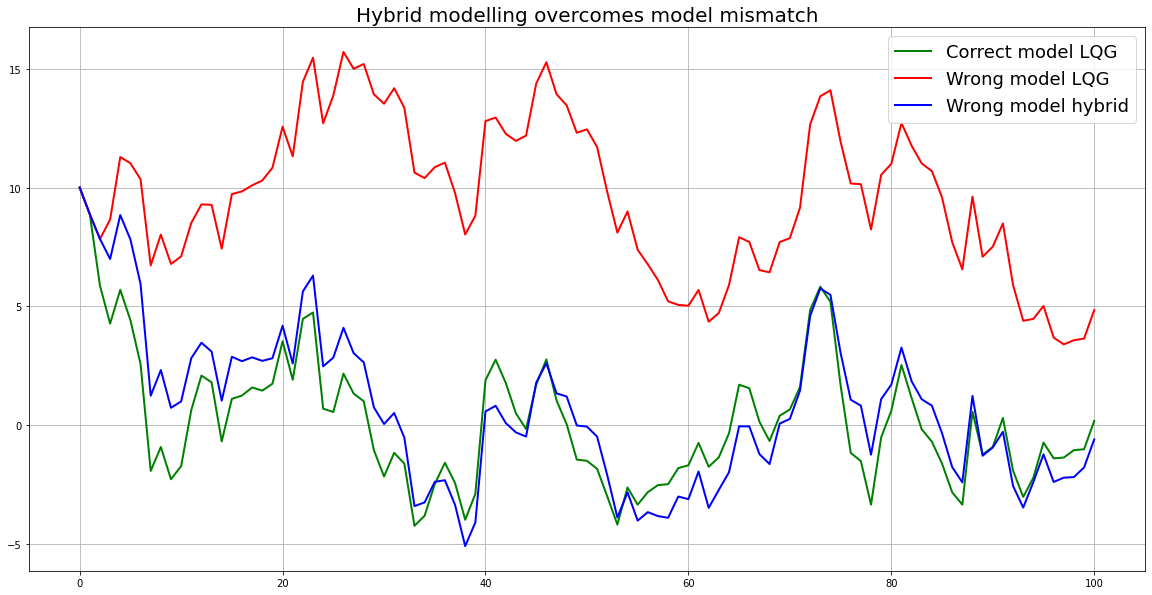

In [ ]:
# plot
lw = 2
plt.figure(figsize=(20,10))
# plt.plot(x_lqr[0,:], label='Correct model LQR', linewidth=lw-1)
plt.plot(x_kf[0,:], 'g-', label='Correct model LQG', linewidth=lw)
# plt.plot(x_lqr_w[0,:], label='Wrong model LQR', linewidth=lw-1)
plt.plot(x_kf_w[0,:], 'r-', label='Wrong model LQG', linewidth=lw)
plt.plot(x_knet[0,:], 'b-', label='Wrong model hybrid', linewidth=lw)
plt.legend(fontsize=18)
plt.grid()
plt.title('Hybrid modelling overcomes model mismatch', fontsize=20)
# plt.savefig(data_path + 'LQG_model_mismatch')

In [ ]:
def latex_table(lqr, lqr_std, kf, kf_std):
    print(f"& {lqr: .3f} & {lqr_std: .3f} & {kf: .3f} & {kf_std: .3f} ")